**Le jeu de données Iris (dit de Fisher)**
est un cadre usuel pour tester les algorithmes de classification supervisée. 

>Testez la fonction svm sur cet exemple (Attention, dans l’affichage, le fait que le nombre de variables soit de dimension 4 implique que l’on doit choisir le plan dans lequel on représente le résultat et la “tranche” que l’on utilise pour les deux autres variables (en pratique, on choisit la valeur moyenne))

In [6]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import numpy as np
import pandas as pd
import plotly.graph_objects as go

iris = load_iris()

df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] +
                  ['target'])  #On place les données iris dans un DataFrame

features = list(df.columns)[:-1]
clf = SVC(kernel='rbf')
X = df[features]
y = df['target']

#On optimise avec skopt comme au tp précédent
space = [Integer(1, 10**3, name='C'), Real(10**-5, 10**0, name='gamma')]


@use_named_args(space)
def objective(**params):
    clf.set_params(**params)

    return 1 - np.mean(
        cross_val_score(clf, X, y, cv=5, n_jobs=-1, scoring="accuracy"))


from skopt import gp_minimize

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Meilleur score=%.4f" % res_gp.fun

'Meilleur score=0.0200'

On entraine un classifieur svm avec les paramètres optimaux obtenus

In [7]:
opt_SVM = SVC(kernel='rbf', C=res_gp.x[0], gamma=res_gp.x[1],
              probability=True).fit(X, y)

On écrit une fonction de slice_plot

In [8]:
def slice_plot(svm, df, col1, col2):
    xmin = df[col1].min()
    xmax = df[col1].max()
    ymin = df[col2].min()
    ymax = df[col2].max()
    lrange = np.arange(xmin, xmax, .02)
    wrange = np.arange(ymin, ymax, .02)
    ll, ww = np.meshgrid(lrange, wrange)
    _Mat = np.c_[ll.ravel(), ww.ravel()]
    _df = pd.DataFrame()
    _col = ""
    for col_name in list(df.columns[:-1]) * 2:
        if col_name == col1:
            _df[col_name] = _Mat[:, 0]
        elif col_name == col2:
            _df[col_name] = _Mat[:, 1]
        else:
            _df[col_name] = df[col_name].mean()
            _col += col_name + ':' + str(round(df[col_name].mean(),
                                               3)) + '<br>'
    proba = svm.predict_proba(_df)
    proba_ = proba.max(axis=-1) - (proba.sum(axis=-1) - proba.max(axis=-1))
    fig = go.Figure()
    fig.add_trace(
        go.Heatmap(x=_df[col1],
                   y=_df[col2],
                   z=proba_,
                   colorscale='RdBu',
                   customdata=proba,
                   hovertemplate="<b>Informations</b><br>" + col1 +
                   ":%{x:.3f}<br>" + col2 + ':%{y:.3f}' + '<br>' +
                   _col[int(len(_col) / 2):] +
                   '''<br>Proba setosa =%{customdata[0]:.3f}
                             <br>Proba versicolor =%{customdata[1]:.3f}
                             <br>Proba virginica =%{customdata[2]:.3f}'''))
    fig.update_layout(title="Frontière SVM",
                      xaxis_title=col1,
                      yaxis_title=col2,
                      font=dict(
                          family="Courier New, monospace",
                          size=18,
                      ))
    fig.show()
    return

Exemple:

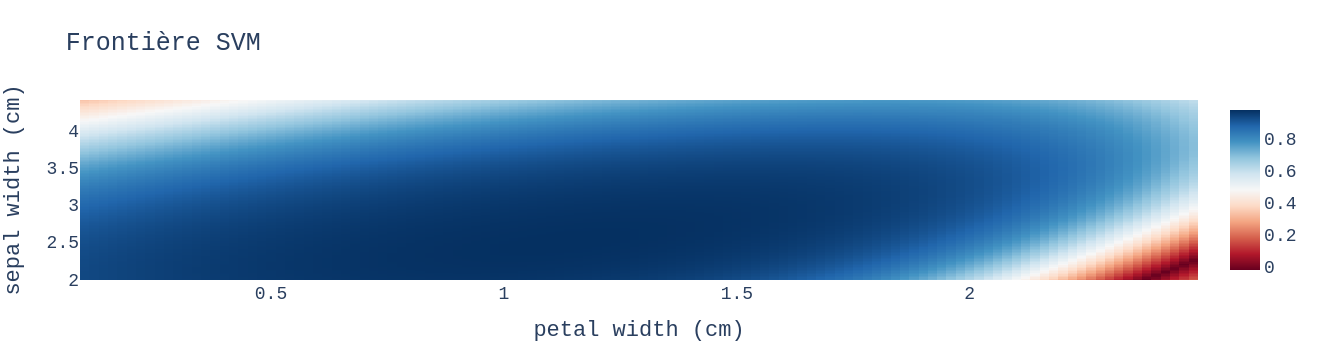

In [13]:
slice_plot(opt_SVM, df, 'petal width (cm)', 'sepal width (cm)')

In [10]:
df


sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
..      ...  
145     2.0  
146     2.0  
147     2.0  
148     2.0  
149     2.0  

[150 rows x 5 columns]